# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to decadal, and mesoscale eddies are weeks-months. 

In [103]:
%run setup.ipynb
%run plotting_functions.ipynb
%run tseries_functions.py
data_dir = Path('../data' )
output_dir = Path('../output') 

In [104]:
from utide import solve, reconstruct
import xarray as xr

In [105]:
ds = xr.open_dataset(data_dir / 'rsl_hawaii.nc')

For right now, we'll do Kahului.

In [106]:
epoch_start = np.datetime64('1983-01-01')
epoch_end = np.datetime64('2001-01-01')
ds_epoch = ds.sel(time=slice(epoch_start, epoch_end))

#extract time and sea level values for HNL station
time = ds_epoch.time.values
time_days = (time - time[0]) / np.timedelta64(1, 'D')

#select only station 59
station = 59
sea_level = ds_epoch.sea_level.sel(record_id=station
                       ).values
station_name = ds_epoch.station_name.sel(record_id=station).item()
print(f'Working on station: {station_name}')





Working on station: Kahului


Estimate the astronomical tides at this location using the selected epoch.

In [107]:
coef = solve(time, sea_level, nodal=False, trend=True, method='robust',lat=ds['lat'].sel(record_id=station).values)

solve: matrix prep ... solution ... done.


In [108]:
time_ALL = ds.time.values
sea_level_ALL = ds.sea_level.sel(record_id=station).values

# find beginning of data in timeseries
start = np.where(~np.isnan(sea_level_ALL))[0][0]
time_ALL = time_ALL[start:]
sea_level_ALL = sea_level_ALL[start:]

tide_ALL = reconstruct(time_ALL, coef)
ntr = sea_level_ALL - tide_ALL.h
ntr_data = pd.DataFrame({'time': time_ALL, 'ntr': ntr, 'sea_level': sea_level_ALL, 'tide': tide_ALL.h})
# ntr_data.to_csv('data/ntr_057b.csv', index=False)

prep/calcs ... done.


In [109]:
ntr_data

,time,ntr,sea_level,tide
0,1950-10-19 02:00:00,29.099293,1006.0,976.900707
1,1950-10-19 03:00:00,1.204955,945.0,943.795045
2,1950-10-19 04:00:00,-20.873711,914.0,934.873711
3,1950-10-19 05:00:00,-29.960820,914.0,943.960820
4,1950-10-19 06:00:00,-49.354150,914.0,963.354150
...,...,...,...,...
651209,2025-01-31 19:00:00,224.128854,1203.0,978.871146
651210,2025-01-31 20:00:00,212.863482,1116.0,903.136518
651211,2025-01-31 21:00:00,194.204832,1093.0,898.795168
651212,2025-01-31 22:00:00,160.193279,1119.0,958.806721


Text(0, 0.5, 'Non-tidal residuals (millimeters)')

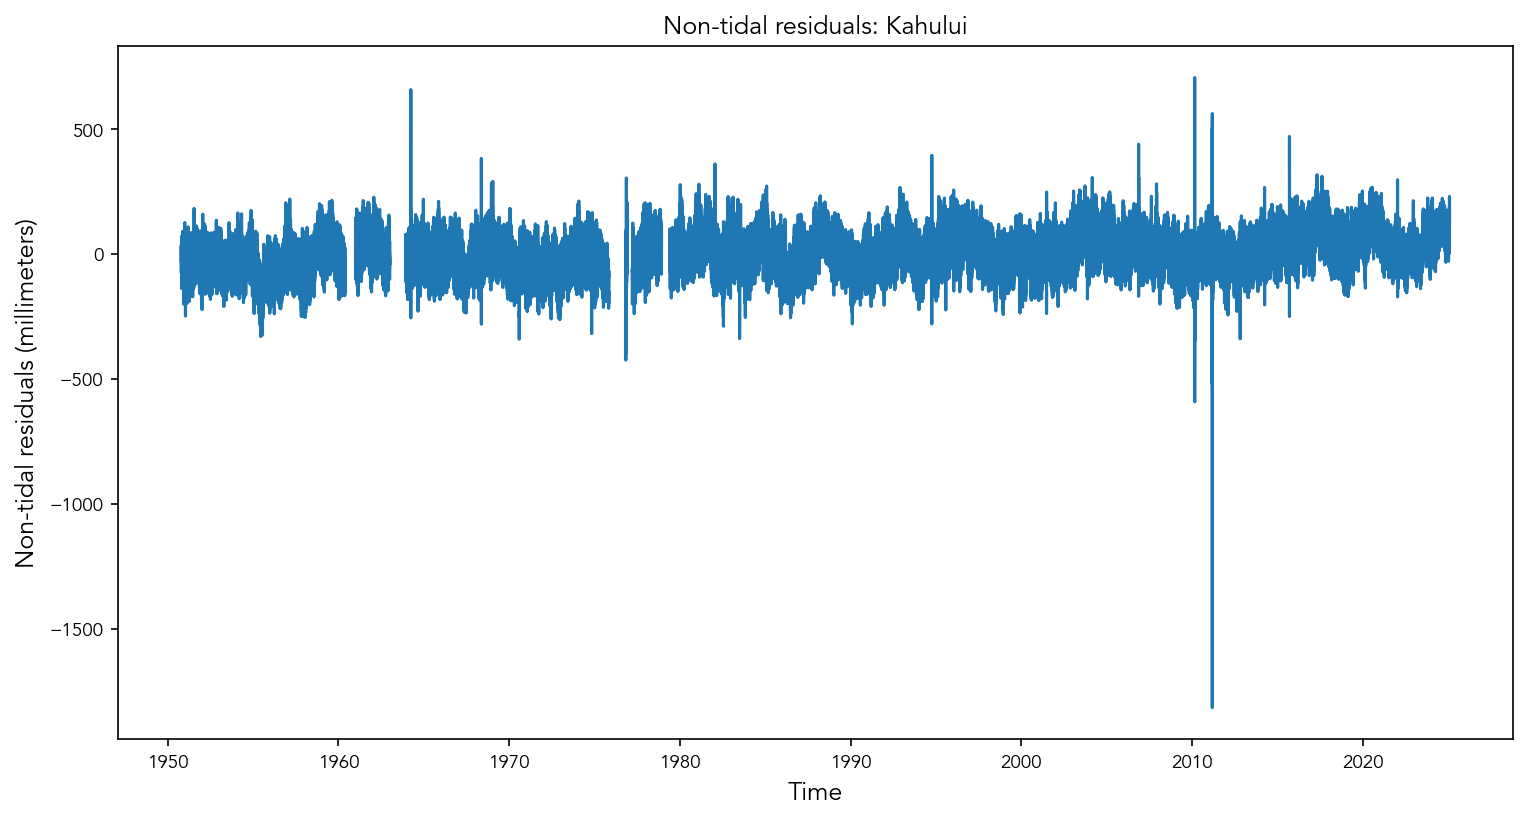

In [110]:
#plot time series
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')

# add title
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

In [111]:
Annualfreq_cpd = 1/365.25
SemiAnnualfreq_cpd = 1/182.625
QtrAnnualfreq_cpd = 1/91.3125
highFreq_cpd = 1/7 # anything higher than a week
monthlyFreq_cpd = 1/(365.25/12)

In [112]:
#detrend the ntr and fill with zeros

def process_trend_with_nan(sea_level_data, time_column='time', weighted=False):
    """
    Compute trends for sea level anomaly data, handling NaNs.
    
    Supports both pandas.DataFrame and xarray.DataArray.
    
    Parameters:
    - sea_level_data: pandas.DataFrame or xarray.DataArray
    - time_column: str, column name for time in a DataFrame (ignored for xarray)
    - weighted: bool, whether to apply cosine weighting (only applies to gridded xarray data)

    Returns:
    - trend_mag: Trend magnitude over time
    - sea_level_trend: Trend values
    - trend_rate: Rate of change per year
    """
    import xarray as xr

    # Handle xarray input
    if isinstance(sea_level_data, xr.DataArray):
        sea_level_data = sea_level_data.transpose('time', ...) if 'time' in sea_level_data.dims else sea_level_data
        time_index = pd.to_datetime(sea_level_data.time.values).to_julian_date()

        # If it's a single time series
        if sea_level_data.ndim == 1:
            y = sea_level_data.values
            mask = ~np.isnan(y)

            if np.any(mask):
                time_masked = time_index[mask]
                y_masked = y[mask]

                slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
                trend = slope * time_index + intercept
                detrended = y - trend

                trend_mag = trend[-1] - trend[0]
                time_mag = (pd.to_datetime(sea_level_data.time.values[-1]) - pd.to_datetime(sea_level_data.time.values[0])).days / 365.25
                trend_rate = trend_mag / time_mag

                return trend_mag, trend, trend_rate
            else:
                return np.nan, np.nan, np.nan

        # For multidimensional xarray data
        sla_flat = sea_level_data.values.reshape(sea_level_data.shape[0], -1)
        detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

        for i in range(sla_flat.shape[1]):
            y = sla_flat[:, i]
            mask = ~np.isnan(y)

            if np.any(mask):
                time_masked = time_index[mask]
                y_masked = y[mask]

                slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
                trend = slope * time_index + intercept

                detrended_flat[:, i] = y - trend

        detrended = detrended_flat.reshape(sea_level_data.shape)
        sea_level_trend = sea_level_data - detrended
        trend_mag = sea_level_trend[-1] - sea_level_trend[0]

        times = pd.to_datetime(sea_level_data['time'].values)
        time_mag = (times[-1] - times[0]).days / 365.25
        trend_rate = trend_mag / time_mag

        if weighted:
            if 'latitude' in sea_level_data.dims:
                weights = np.cos(np.deg2rad(sea_level_data.latitude))
                weights.name = 'weights'

                trend_mag = (trend_mag * weights).mean()
                trend_rate = (trend_rate * weights).mean()
                sea_level_trend = (sea_level_trend * weights).mean(dim=['latitude', 'longitude'])
            else:
                raise ValueError("Weighted trend calculation requires latitude coordinate.")

        return trend_mag, sea_level_trend, trend_rate

    # Handle DataFrame input
    elif isinstance(sea_level_data, pd.DataFrame):
        if time_column not in sea_level_data.columns:
            raise ValueError(f"Time column '{time_column}' not found in DataFrame.")

        # Convert time to Julian date
        time_index = pd.to_datetime(sea_level_data[time_column]).map(lambda x: x.toordinal() + 1721424.5)



        # Exclude the time column from analysis
        data_columns = [col for col in sea_level_data.columns if col != time_column]
        
        trend_magnitudes = {}
        trend_series = {}
        trend_rates = {}

        for col in data_columns:
            y = sea_level_data[col].values
            mask = ~np.isnan(y)

            if np.any(mask):
                time_masked = time_index[mask]
                y_masked = y[mask]

                slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
                trend = np.array(slope * time_index + intercept)
                detrended = y - trend

                
                if len(trend) > 1:
                    trend_mag = trend[-1] - trend[0]
                    time_mag = (pd.to_datetime(sea_level_data[time_column].iloc[-1]) - pd.to_datetime(sea_level_data[time_column].iloc[0])).days / 365.25
                    trend_rate = trend_mag / time_mag
                else:
                    trend_mag = np.nan
                    trend_rate = np.nan

                trend_magnitudes[col] = trend_mag
                trend_series[col] = trend
                trend_rates[col] = trend_rate
            else:
                trend_magnitudes[col] = np.nan
                trend_series[col] = np.nan
                trend_rates[col] = np.nan

        return trend_magnitudes, trend_series, trend_rates

    else:
        raise TypeError("Input must be an xarray.DataArray or pandas.DataFrame.")



ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(ntr_data)


Text(0, 0.5, 'Non-tidal residuals (millimeters)')

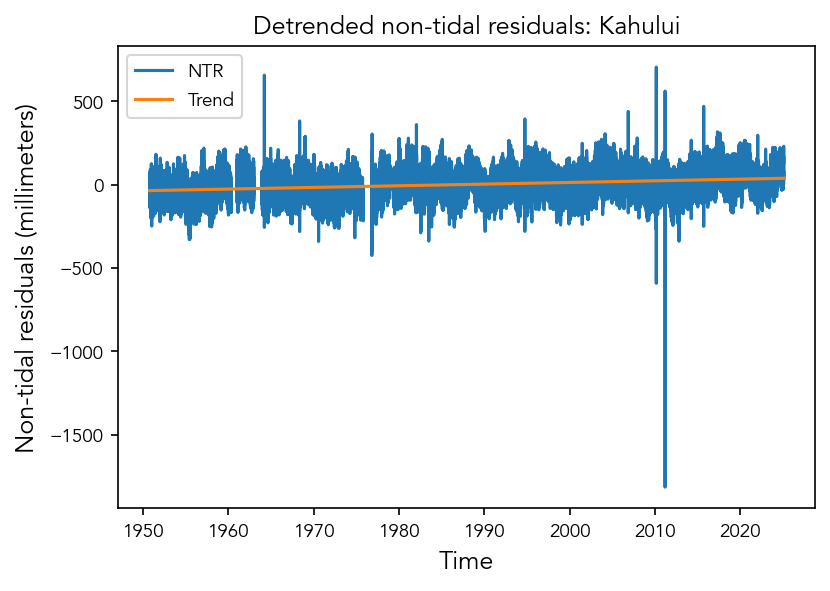

In [113]:
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

In [114]:
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr']
ntr_data

,time,ntr,sea_level,tide,ntr_detrended
0,1950-10-19 02:00:00,29.099293,1006.0,976.900707,64.221333
1,1950-10-19 03:00:00,1.204955,945.0,943.795045,36.326995
2,1950-10-19 04:00:00,-20.873711,914.0,934.873711,14.248329
3,1950-10-19 05:00:00,-29.960820,914.0,943.960820,5.161220
4,1950-10-19 06:00:00,-49.354150,914.0,963.354150,-14.232110
...,...,...,...,...,...
651209,2025-01-31 19:00:00,224.128854,1203.0,978.871146,185.483860
651210,2025-01-31 20:00:00,212.863482,1116.0,903.136518,174.218488
651211,2025-01-31 21:00:00,194.204832,1093.0,898.795168,155.559838
651212,2025-01-31 22:00:00,160.193279,1119.0,958.806721,121.548285


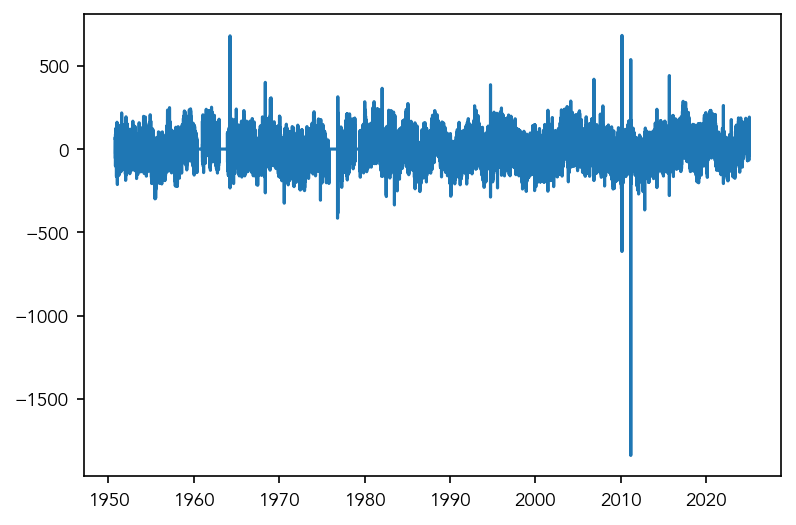

In [115]:
#replace all nans with zeros and plot
ntr_data['ntr_detrended'] = ntr_data['ntr_detrended'].fillna(0)

#if there are time 

plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR Detrended')

In [116]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)

# Remove the lowest frequencies first (decadal and multi-year)
# Filter out Nodal Component
ntr_noNodal, ntr_nodal = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs, 1/(365.25*18.61), width=0.00001)


#>20 years
ntr_lowFreq, ntr_highFreq = butterworth_lowpass(ntr_noNodal, time_diffs, 1/(365.25*20), order=3, padtype='even', padlen=3)
#10-20 years
ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/(365.25*10), order=2) 

#1-10 years
ntr_multiyear, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/(365.25*1), order=2)

# Filter out annual, semi-annual, and quarter-annual components
ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_highFreq, time_diffs, Annualfreq_cpd, width=0.002)
ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, SemiAnnualfreq_cpd, width=0.002)
ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, QtrAnnualfreq_cpd, width=0.002)


# 1 month-1 year
ntr_subAnnual, ntr_highFreq = butterworth_lowpass(ntr_noQtrAnnual, time_diffs, monthlyFreq_cpd, order=2)

# Remove high frequencies (weekly to hourly)
# ntr_weekly is timescales longer than 7 days but less than 1 month
ntr_Weekly, ntr_subWeekly = butterworth_lowpass(ntr_highFreq, time_diffs, highFreq_cpd, order=2)

ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual


In [117]:
# make dataframe of filtered data
ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr_detrended'], 
                             'sea_level': ntr_data['sea_level'],
                             'tide': ntr_data['tide'],
                             'Nodal': ntr_nodal, 
                             '> 20 years': ntr_lowFreq, 
                             '10-20 year': ntr_decadal, 
                             '1-10 year': ntr_multiyear, 
                             'Seasonal': ntr_Seasonal, 
                             '1 month - 1 year': ntr_subAnnual, 
                             '1 week - 1 month': ntr_Weekly, 
                             '< 1 week': ntr_subWeekly})
ntr_filtered

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')

In [118]:
# get cumulative sums of Nodal, > 20 years, 10-20 years, 1-10 years, Seasonal, 1 month - 1 year, 1 week - 1 month, and < 1 week columns
# do the cumsum of ntr_filtered columns Nodal, > 20 years, 10-20 year, 1-10 year, Seasonal, 1 month - 1 year, 1 week - 1 month, and < 1 week by column (horizontal)
ntr_cumsum = ntr_filtered[['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week']].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds
# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')


Nodal               10.521659
> 20 years          11.828244
10-20 year          18.564831
1-10 year           38.494348
Seasonal            44.539908
1 month - 1 year    48.881356
1 week - 1 month    51.971852
< 1 week            62.918573
dtype: float64

In [119]:
ntr_filtered

,time,ntr,sea_level,tide,Nodal,> 20 years,10-20 year,1-10 year,Seasonal,1 month - 1 year,1 week - 1 month,< 1 week
0,1950-10-19 02:00:00,64.221333,1006.0,976.900707,-7.823615,2.863659,75.430760,0.089835,-30.521086,31.464460,4.838363,-12.121042
1,1950-10-19 03:00:00,36.326995,945.0,943.795045,-7.824104,2.863678,75.427311,0.056854,-30.570800,31.103047,3.510025,-38.239017
2,1950-10-19 04:00:00,14.248329,914.0,934.873711,-7.824592,2.863696,75.423863,0.023872,-30.620419,30.741897,2.189654,-58.549643
3,1950-10-19 05:00:00,5.161220,914.0,943.960820,-7.825080,2.863714,75.420415,-0.009110,-30.669943,30.381039,0.879189,-65.879005
4,1950-10-19 06:00:00,-14.232110,914.0,963.354150,-7.825569,2.863733,75.416966,-0.042092,-30.719372,30.020502,-0.419537,-83.526742
...,...,...,...,...,...,...,...,...,...,...,...,...
651209,2025-01-31 19:00:00,185.483860,1203.0,978.871146,-7.821172,4.990545,-9.339025,69.973478,-30.271116,10.353686,46.514370,101.083094
651210,2025-01-31 20:00:00,174.218488,1116.0,903.136518,-7.821661,4.990545,-9.339025,69.973478,-30.321296,10.355003,46.610881,89.770563
651211,2025-01-31 21:00:00,155.559838,1093.0,898.795168,-7.822150,4.990545,-9.339025,69.973477,-30.371383,10.356117,46.690595,71.081661
651212,2025-01-31 22:00:00,121.548285,1119.0,958.806721,-7.822638,4.990545,-9.339025,69.973477,-30.421378,10.357045,46.755063,37.055195


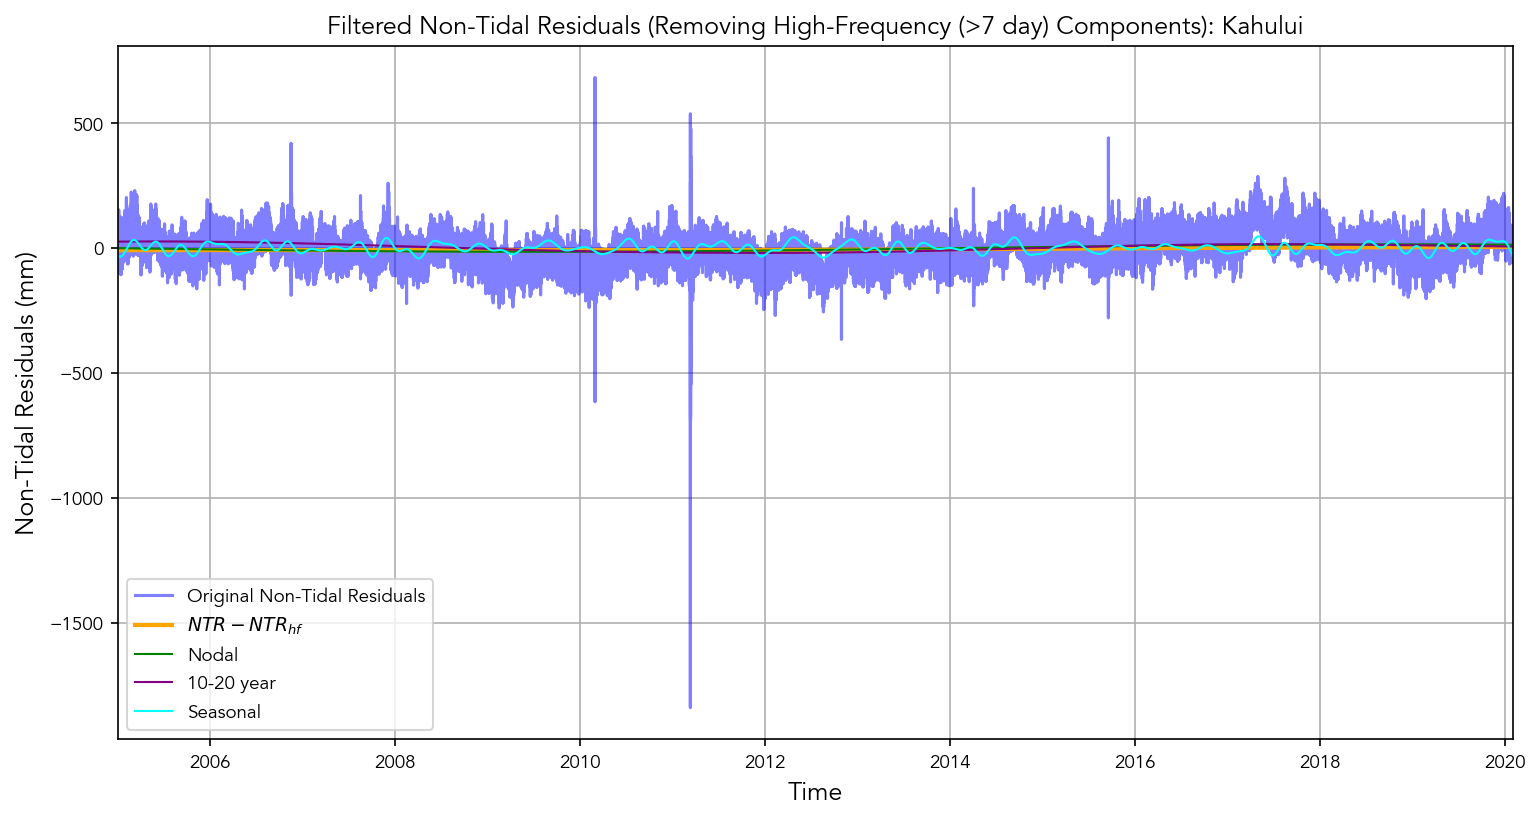

In [120]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

plt.plot(ntr_filtered['time'], ntr_filtered['Nodal'], label='Nodal', color='green', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['10-20 year'], label='10-20 year', color='purple', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1-10 year'], label='1-10 year', color='brown', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1 month - 1 year'], label='1 month - 1 year', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 1 month'], label='1 week - 1 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('2005-01-01'), pd.Timestamp('2020-02-01'))
plt.show()

In [121]:
ntr_component_stds

ntr                  62.918573
sea_level           225.369461
tide                211.019346
Nodal                10.521659
> 20 years            5.177692
10-20 year           13.947941
1-10 year            31.964988
Seasonal             18.172923
1 month - 1 year     15.659635
1 week - 1 month     13.987612
< 1 week             34.386957
dtype: object

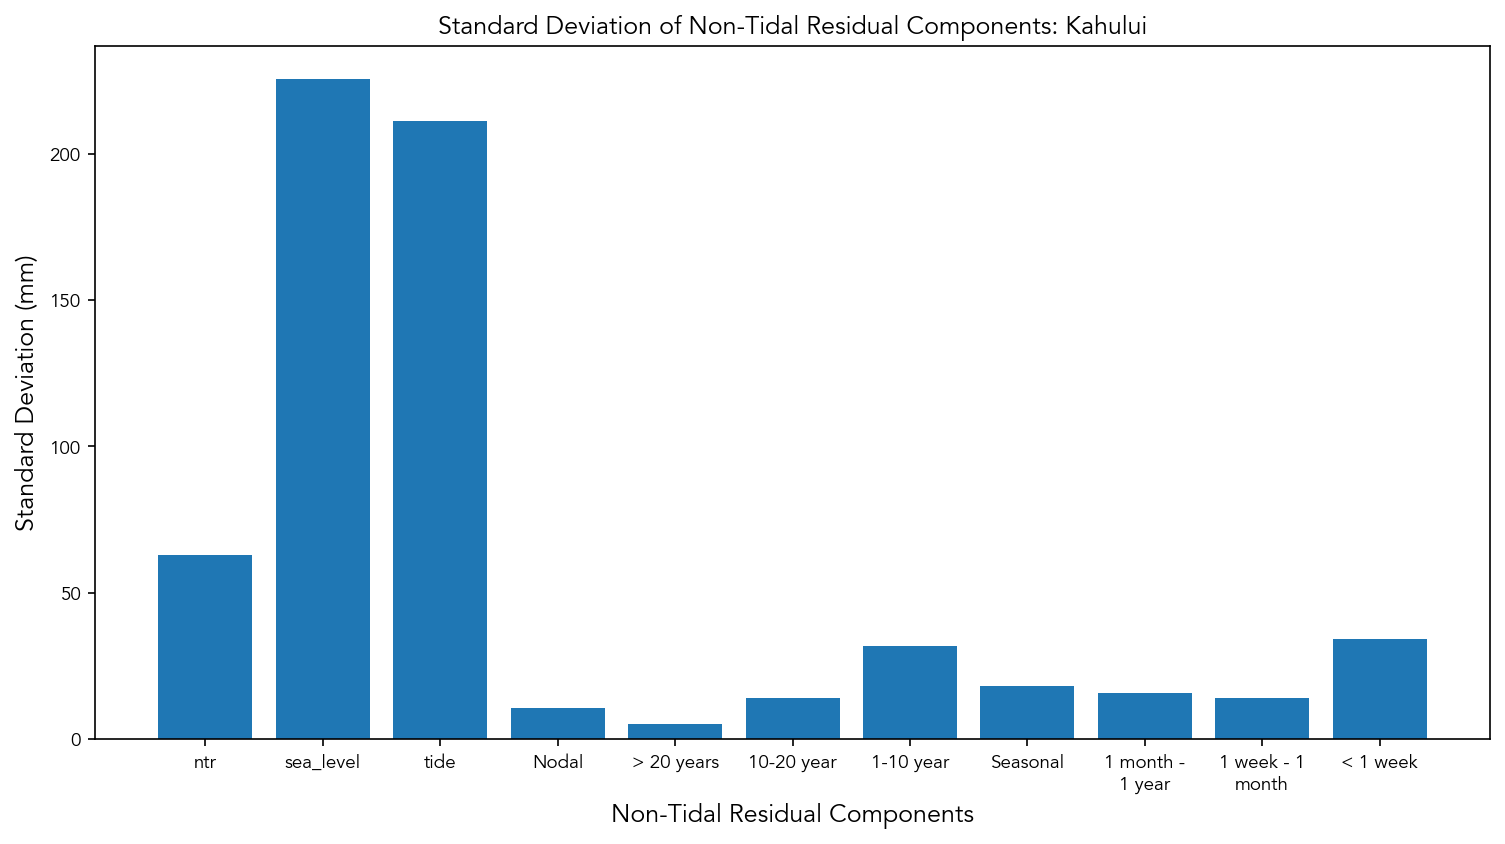

In [122]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
component_names = ntr_component_stds.index
component_stds = ntr_component_stds
ax.bar(component_names, component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=10)) for label in component_names]
plt.xticks(range(len(component_names)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

In [123]:
component_stds

ntr                  62.918573
sea_level           225.369461
tide                211.019346
Nodal                10.521659
> 20 years            5.177692
10-20 year           13.947941
1-10 year            31.964988
Seasonal             18.172923
1 month - 1 year     15.659635
1 week - 1 month     13.987612
< 1 week             34.386957
dtype: object

## Plot components
Make a bar plot of average contributions to water levels.

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_91732/3394451137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))


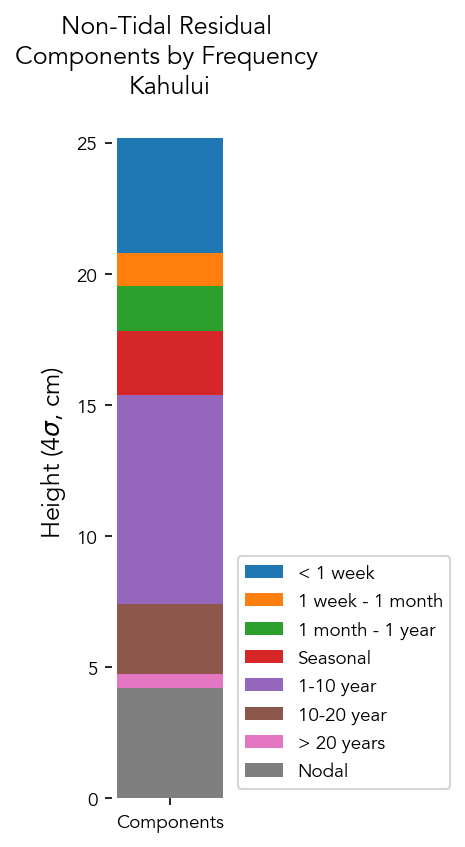

In [124]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))

# Plot stacked bars
bottom = 0
for i in range(len(ntr_cumsum_stds.index)-1, -1, -1):
    ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (4$\sigma$, cm)')
ax.set_title('Non-Tidal Residual \nComponents by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)


It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are indepedent signals and therefore the standard deviations cannot be added together to represent the total standard deviations of the whole signal.

In [125]:
# get dates of extreme events
top10tableName = 'SL_top_10_table_' + station_name + '.csv'
extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [126]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest

DatetimeIndex(['2015-09-17 15:00:00', '1994-10-04 23:00:00',
               '1995-11-24 14:00:00', '2020-12-15 14:00:00',
               '2017-08-21 00:00:00', '2021-12-05 14:00:00',
               '2019-12-26 13:00:00', '2023-08-02 01:00:00',
               '2020-07-21 01:00:00', '2020-07-06 02:00:00'],
              dtype='datetime64[ns]', freq=None)

In [127]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values

ntr_filtered_extremes_high


,time,ntr,sea_level,tide,Nodal,> 20 years,10-20 year,1-10 year,Seasonal,1 month - 1 year,1 week - 1 month,< 1 week
385365,1994-10-04 23:00:00,386.149224,1841.0,1446.321045,-4.136056,0.345184,16.405355,-9.586521,15.424459,10.741552,15.122387,341.832866
395340,1995-11-24 14:00:00,193.710335,1838.0,1634.628946,1.534330,-2.284839,13.241555,31.118238,11.593531,28.311686,22.812835,87.382999
569029,2015-09-17 15:00:00,441.165019,1860.0,1389.498885,7.437487,-1.557116,7.210707,-17.710939,-7.675426,-2.948057,-18.307311,474.715673
585910,2017-08-21 00:00:00,146.321696,1822.0,1644.428229,13.728980,1.821722,15.684743,55.135866,17.840255,41.382958,13.422740,-12.695568
606491,2019-12-26 13:00:00,158.977680,1807.0,1614.442302,13.714470,4.260900,6.749408,22.938592,27.639290,21.098664,35.879808,26.696547
611112,2020-07-06 02:00:00,155.994066,1796.0,1605.901203,12.472890,4.533203,3.701020,72.589983,44.413413,1.346283,7.678332,9.258941
611471,2020-07-21 01:00:00,142.159702,1797.0,1620.694786,12.359276,4.550745,3.430305,75.874852,27.422758,14.882802,2.835263,0.803703
615012,2020-12-15 14:00:00,131.815752,1825.0,1658.639084,11.115191,4.698623,0.513048,52.838862,1.180163,19.864943,9.523414,32.081509
623532,2021-12-05 14:00:00,94.062016,1817.0,1687.427674,7.325133,4.902272,-6.701762,-40.224651,16.252029,19.830490,50.252924,42.425582
638039,2023-08-02 01:00:00,71.145567,1800.0,1691.699298,-0.671836,4.986810,-10.465720,6.370453,46.028489,1.474529,0.721574,22.701267


In [128]:
ntr_filtered_extremes_low

,time,ntr,sea_level,tide,Nodal,> 20 years,10-20 year,1-10 year,Seasonal,1 month - 1 year,1 week - 1 month,< 1 week
417976,1998-06-24 18:00:00,-151.464438,421.0,560.239966,12.331957,-8.396550,-18.784632,-40.211108,-36.983758,-29.178525,-0.656810,-29.585012
422572,1999-01-02 06:00:00,-125.146783,431.0,543.400317,13.607684,-9.327270,-24.531543,-40.798976,-12.165074,44.854170,-4.400335,-92.385438
444283,2001-06-24 21:00:00,-253.101445,441.0,678.897256,13.578167,-11.048217,-20.065497,11.121663,27.107216,7.044733,9.140113,-289.979624
510435,2009-01-10 05:00:00,-109.491647,454.0,540.791946,-14.672469,-8.266415,-3.746463,-24.776992,-6.899598,-0.049359,-4.867489,-46.212861
513689,2009-05-25 19:00:00,-114.879332,443.0,534.812604,-14.867003,-8.320450,-7.526862,-36.488324,0.894068,-9.756053,-18.895640,-19.919069
514384,2009-06-23 18:00:00,-104.145169,453.0,533.999599,-14.878239,-8.328882,-8.269055,-30.123336,0.886531,-17.141733,-5.711338,-20.579116
518981,2010-01-01 07:00:00,-133.819476,461.0,571.151911,-14.683422,-8.346871,-12.533706,-28.359931,1.812074,-2.772914,-1.515818,-67.418887
520369,2010-02-28 03:00:00,-615.083248,340.0,931.257997,-14.533332,-8.336865,-13.594236,-27.899490,-13.421069,-0.155292,31.725260,-568.868224
529405,2011-03-11 15:00:00,-1839.486167,-652.0,1162.638677,-12.567602,-8.042266,-18.264356,26.865804,-35.940653,-27.816794,-65.169711,-1698.550589
536332,2011-12-25 06:00:00,-181.519550,412.0,567.886351,-10.016689,-7.496058,-19.498083,-21.958197,-31.766742,-31.373778,-27.213317,-32.196687


In [129]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [130]:
#get MHHW from ds
mhhw = ds_epoch['MHHW'].sel(record_id=station).values
mhhw

# get mllw from ds (except we don't have that yet so we'll just manually calculate it)
mllw = tide_min_daily.mean()
mllw

740.3573933245341

In [131]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,> 20 years,10-20 year,1-10 year,Seasonal,1 month - 1 year,1 week - 1 month,< 1 week
385365,1994-10-04 23:00:00,386.149224,1841.0,1446.321045,-4.136056,0.345184,16.405355,-9.586521,15.424459,10.741552,15.122387,341.832866
395340,1995-11-24 14:00:00,193.710335,1838.0,1634.628946,1.534330,-2.284839,13.241555,31.118238,11.593531,28.311686,22.812835,87.382999
569029,2015-09-17 15:00:00,441.165019,1860.0,1389.498885,7.437487,-1.557116,7.210707,-17.710939,-7.675426,-2.948057,-18.307311,474.715673
585910,2017-08-21 00:00:00,146.321696,1822.0,1644.428229,13.728980,1.821722,15.684743,55.135866,17.840255,41.382958,13.422740,-12.695568
606491,2019-12-26 13:00:00,158.977680,1807.0,1614.442302,13.714470,4.260900,6.749408,22.938592,27.639290,21.098664,35.879808,26.696547
611112,2020-07-06 02:00:00,155.994066,1796.0,1605.901203,12.472890,4.533203,3.701020,72.589983,44.413413,1.346283,7.678332,9.258941
611471,2020-07-21 01:00:00,142.159702,1797.0,1620.694786,12.359276,4.550745,3.430305,75.874852,27.422758,14.882802,2.835263,0.803703
615012,2020-12-15 14:00:00,131.815752,1825.0,1658.639084,11.115191,4.698623,0.513048,52.838862,1.180163,19.864943,9.523414,32.081509
623532,2021-12-05 14:00:00,94.062016,1817.0,1687.427674,7.325133,4.902272,-6.701762,-40.224651,16.252029,19.830490,50.252924,42.425582
638039,2023-08-02 01:00:00,71.145567,1800.0,1691.699298,-0.671836,4.986810,-10.465720,6.370453,46.028489,1.474529,0.721574,22.701267


In [132]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std

extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low, ntr_component_stds, mllw, tide_min_daily_std)


In [133]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'))
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.columns,rotation=60, ha='right')

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

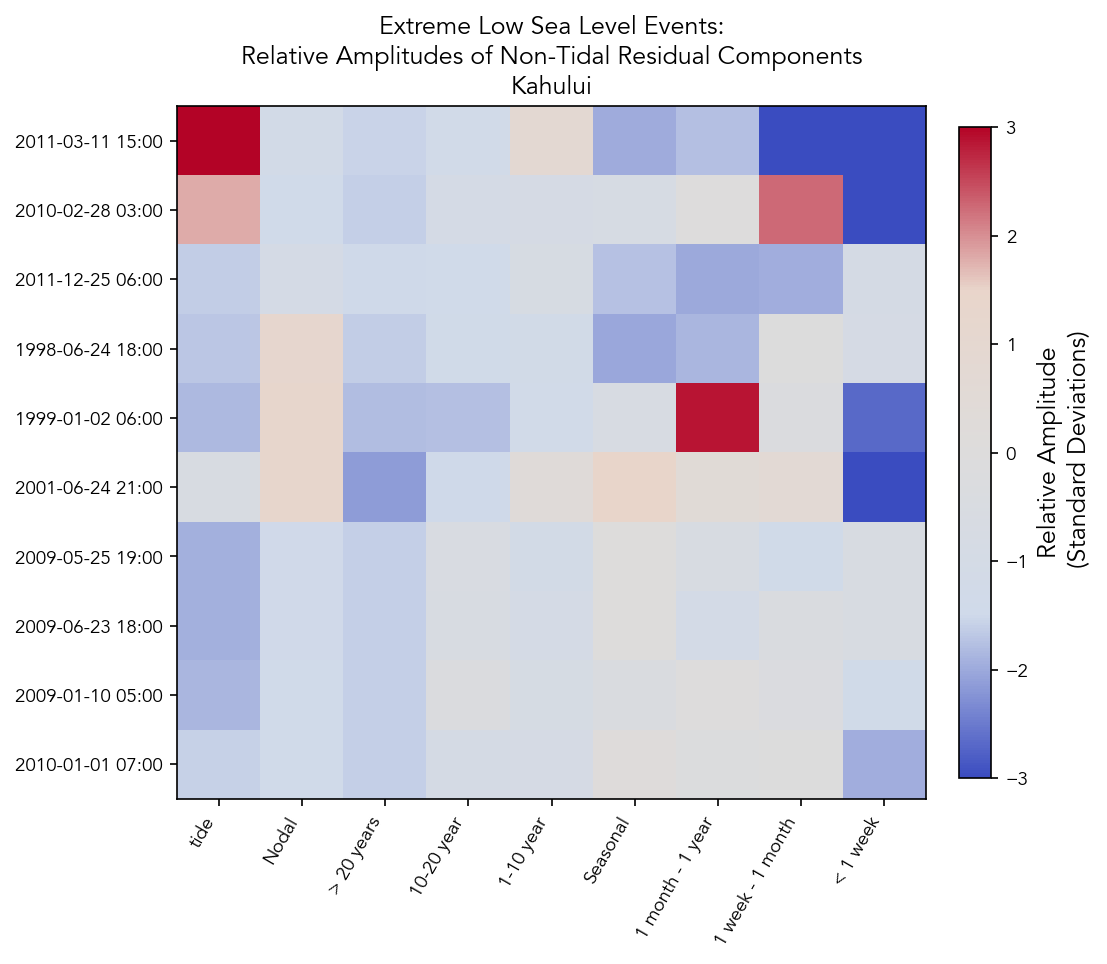

In [134]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


../output/SL_rankings_NTR_relative_amplitudes_top10_Kahului_high.png


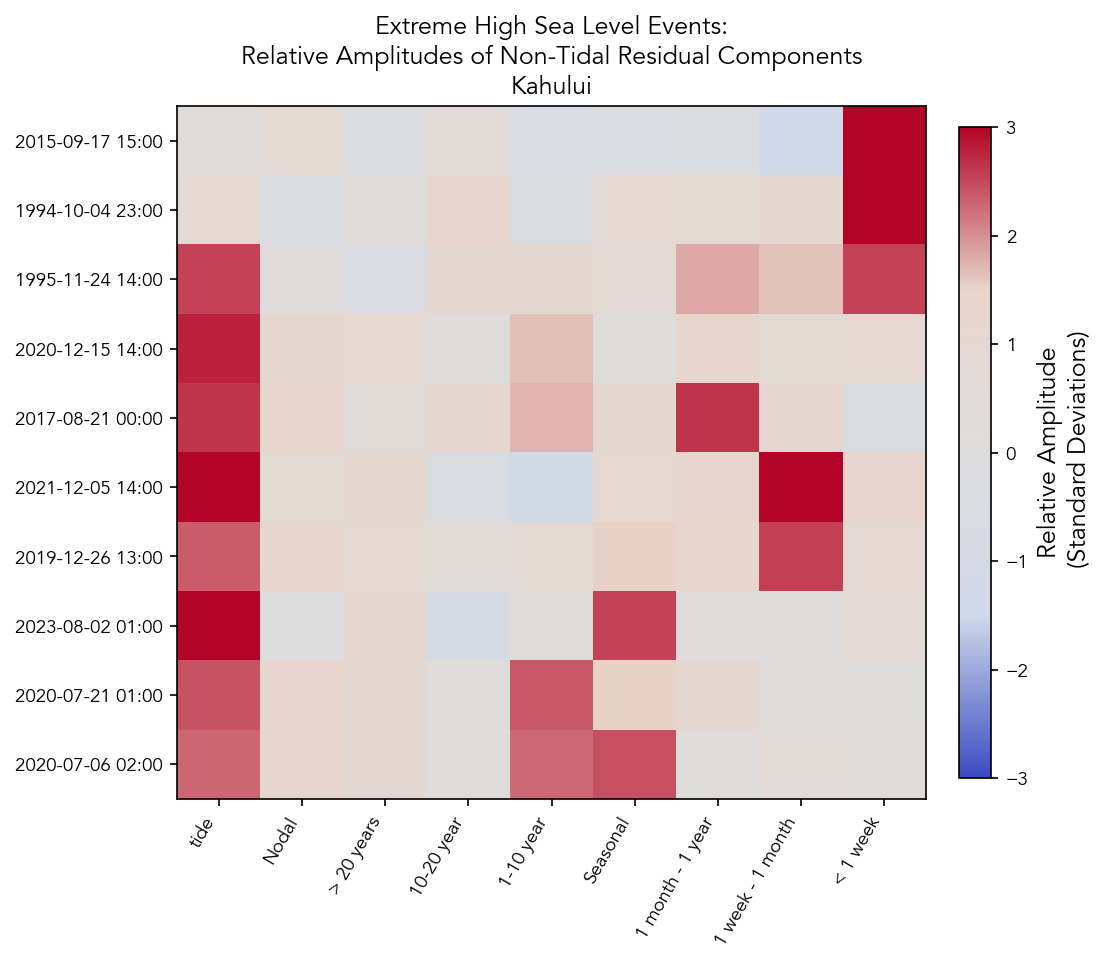

In [135]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')